In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

Load the data from jester-data-1.csv


In [7]:
rawdf = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", na_values=[99], header=None)

In [8]:
df = rawdf.replace('99', np.NaN)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [9]:
df = df.drop(df.columns[0], axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [10]:
melteddf = df.melt(var_name="Joke_ID", value_name="Value")

melteddf = melteddf.groupby('Joke_ID').agg({'Value':'mean'})

melteddf = melteddf.sort_values(by=['Value'], ascending=False)

print('Best rated joke is:')
print(melteddf.head(1))



print('Worst rated joke is:')
print(melteddf.tail(1))

Best rated joke is:
            Value
Joke_ID          
50       3.665085
Worst rated joke is:
           Value
Joke_ID         
58      -3.83388


In [11]:
df = df.fillna(99)

In [12]:
arr = df.values
print(arr.shape)

(24983, 100)


In [13]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [14]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])


In [15]:
new_arr, idx = replace(arr, 0.1)

In [16]:
arr[idx[0][0], idx[1][0]]

6.65

In [17]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [18]:
new_arr.shape

(24983, 100)

In [19]:
n_latent_factors = 2

user_ratings = new_arr
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [20]:

def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                  if rating != 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/10:	MSE=24.528025
Iteration 1/10:	MSE=22.403056
Iteration 2/10:	MSE=20.566159
Iteration 3/10:	MSE=18.567627
Iteration 4/10:	MSE=17.778560
Iteration 5/10:	MSE=17.677392
Iteration 6/10:	MSE=17.702464
Iteration 7/10:	MSE=17.769999
Iteration 8/10:	MSE=17.868471
Iteration 9/10:	MSE=18.008537


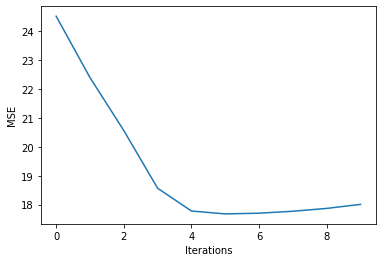

In [21]:

num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [22]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[-3.083, -3.459, -5.1  , ..., -2.212, -7.033, -1.815],
       [ 2.103,  2.296,  2.785, ...,  2.061,  3.383,  2.034],
       [ 6.791,  7.294,  7.691, ...,  7.688,  8.272,  8.058],
       ...,
       [-0.187, -0.209, -0.296, ..., -0.145, -0.398, -0.126],
       [-1.123, -1.29 , -2.182, ..., -0.548, -3.223, -0.29 ],
       [ 3.667,  3.912,  3.859, ...,  4.384,  3.869,  4.687]])

In [23]:
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]

comparison_data = pd.DataFrame(values)

comparison_data.columns = df.columns

In [24]:
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(99.0, -3.0827365054273885)","(8.79, -3.4593029191884765)","(-9.66, -5.099912730250534)","(-8.16, -9.091124484335912)","(-7.52, -2.64769003300427)","(-8.5, -1.6296632063230383)","(-9.85, -5.190091069619703)","(4.17, -4.525494841015304)","(-8.98, -8.391993717513927)","(-4.76, -4.0386578987241455)","(-8.5, -1.742047783477538)","(-6.75, -1.3240441717187266)","(-7.18, -7.137938589373146)","(8.45, -1.2524483085923535)","(-7.18, -7.85485402880548)","(99.0, -11.140784811049404)","(-7.43, -5.033044263864783)","(-9.81, -6.4134339418023)","(-9.85, -4.670995378454823)","(-9.85, -7.72351017013402)","(-9.37, 0.7288141018954015)","(99.0, -4.185570971494756)","(-4.37, -6.35670436623205)","(99.0, -10.931612875019756)","(-8.5, -4.571881047829305)","(1.12, -1.6008638410747922)","(7.82, 3.3489581600492215)","(99.0, -1.8440432398582913)","(9.13, 3.5998090811657937)","(-7.43, -8.1098972987653)","(2.14, 1.3481362551208995)","(-4.08, 3.2158574203030077)","(-9.08, -10.268817735408836)","(99.0, -2.84849566836346)","(5.05, 2.8845424652539324)","(4.95, 3.8696259411009137)","(99.0, -9.978730880309799)","(-8.4, -3.9939274505254274)","(99.0, -2.635353439984954)","(-8.4, -4.132124112236568)",...,"(8.59, 0.9694368338240111)","(3.59, 1.9831525275493906)","(-6.84, -6.779112512608901)","(-9.03, -9.638075744512424)","(2.82, 1.5461665594455525)","(99.0, 1.42147028449753)","(-9.08, -10.161748958145479)","(8.3, 1.4795569191588331)","(5.68, 1.7089201204109776)","(-4.81, -5.242996664235523)","(99.0, -7.810001299710878)","(99.0, 1.3985208979682338)","(99.0, -3.1034883774496715)","(99.0, -9.444705438900382)","(99.0, -6.896498950812875)","(99.0, -0.02522742753738168)","(99.0, -4.923648273732885)","(-9.42, -3.1405023415900257)","(99.0, -6.777800096984194)","(99.0, -4.281626365311099)","(99.0, -1.4389199176838952)","(-7.72, -5.1199548311537)","(99.0, -1.1637781901267683)","(99.0, -5.410807975505466)","(99.0, -4.890079057285563)","(99.0, -6.630446045620665)","(99.0, -1.6886359387125778)","(99.0, -1.8854736512249182)","(99.0, 2.2000271523837043)","(99.0, -6.2748514427171544)","(2.82, -2.114161470909848)","(99.0, -3.980187845760846)","(99.0, -0.4256084604772233)","(99.0, -5.834819716010275)","(99.0, -4.777601103581575)","(99.0, -3.8472706053582604)","(-5.63, -3.1827070827185207)","(99.0, -2.2117718213588633)","(99.0, -7.0331776668366865)","(99.0, -1.8154809864969574)"
1,"(4.08, 2.103382423208937)","(-0.29, 2.296363597491377)","(6.36, 2.7850862237598735)","(4.37, 3.7238006959393584)","(-2.38, 1.7922499393433042)","(99.0, 2.073881654137064)","(-0.73, 2.4023835598675682)","(-5.34, 1.7829607879617897)","(8.88, 3.5913354890275304)","(9.22, 2.4796879493375665)","(6.75, 2.1508685225000757)","(8.64, 2.1240986821051817)","(4.42, 2.483784273876596)","(99.0, 2.1146632108361514)","(4.56, 2.5361233419295206)","(-0.97, 3.345206866904511)","(99.0, 2.078698827838249)","(-0.68, 2.5957266947985977)","(3.3, 2.5167903742123285)","(-1.21, 3.256059207157097)","(0.87, 1.561886053800604)","(8.64, 2.828107117893268)","(8.35, 3.2274740969824087)","(9.17, 4.1567670603439595)","(0.05, 2.871804074622998)","(7.57, 2.1826005452295623)","(4.71, 0.6348913185672003)","(0.87, 2.1074765357151355)","(-0.39, 0.5252780196131622)","(6.99, 3.788585091104503)","(6.5, 1.257642529631119)","(-0.92, 0.7149387625493335)","(7.14, 4.280912352038456)","(9.03, 2.4862233130671156)","(-1.8, 0.8235669600585055)","(0.73, 0.3833729105206046)","(7.09, 3.9390828129645357)","(3.4, 2.7384220055313886)","(-0.87, 2.4751452030060483)","(7.91, 2.911131004068674)",...,"(-6.7, 1.4123693894903342)","(-3.35, 1.101040289740753)","(-9.03, 3.539311170389555)","(4.47, 4.0595594752342645)","(4.08, 1.217571071270055)","(99.0, 1.2744483221525742)","(8.74, 4.249761566836319)","(99.0, 1.2062190213780488)","(0.78, 1

In [25]:
file_name = 'movies_latent_factors.xlsx'
Itemdf = pd.read_excel(file_name, sheet_name='Items')
Userdf = pd.read_excel(file_name, sheet_name='Users')

In [26]:
Itemdf_transposed = Itemdf.iloc[:,2:].T
Userdf_new = Userdf.drop(Userdf.columns[0], axis=1)

In [27]:
rawdf.shape

(24983, 101)

In [ ]:
tle = []
for i, row in Itemdf.iterrows():
  print('movie id: ' + str(row[0]) + ' Name: ' + row[1])
  tle.append('movie id: ' + str(row[0]) + ' Name: ' + row[1])

In [35]:
temp = Userdf_new.dot(Itemdf_transposed)
temp.columns = tle
temp

,movie id: 11 Name: Star Wars: Episode IV - A New Hope (1977),movie id: 12 Name: Finding Nemo (2003),movie id: 13 Name: Forrest Gump (1994),movie id: 14 Name: American Beauty (1999),movie id: 22 Name: Pirates of the Caribbean: The Curse of the Black Pearl (2003),movie id: 24 Name: Kill Bill: Vol. 1 (2003),movie id: 38 Name: Eternal Sunshine of the Spotless Mind (2004),movie id: 63 Name: Twelve Monkeys (a.k.a. 12 Monkeys) (1995),movie id: 77 Name: Memento (2000),movie id: 85 Name: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),movie id: 98 Name: Gladiator (2000),movie id: 105 Name: Back to the Future (1985),movie id: 107 Name: Snatch (2000),movie id: 114 Name: Pretty Woman (1990),movie id: 120 Name: The Lord of the Rings: The Fellowship of the Ring (2001),movie id: 121 Name: The Lord of the Rings: The Two Towers (2002),movie id: 122 Name: The Lord of the Rings: The Return of the King (2003),movie id: 134 Name: O Brother Where Art Thou? (2000),movie id: 141 Name: Donnie Darko (2001),movie id: 146 Name: Crouching Tiger Hidden Dragon (Wo hu cang long) (2000),movie id: 153 Name: Lost in Translation (2003),movie id: 155 Name: The Dark Knight (2008),movie id: 161 Name: Ocean's Eleven (2001),movie id: 180 Name: Minority Report (2002),movie id: 187 Name: Sin City (2005),movie id: 194 Name: Amelie (2001),movie id: 197 Name: Braveheart (1995),movie id: 238 Name: The Godfather (1972),movie id: 243 Name: High Fidelity (2000),movie id: 268 Name: Batman (1989),movie id: 272 Name: Batman Begins (2005),movie id: 274 Name: The Silence of the Lambs (1991),movie id: 275 Name: Fargo (1996),movie id: 278 Name: The Shawshank Redemption (1994),movie id: 280 Name: Terminator 2: Judgment Day (1991),movie id: 329 Name: Jurassic Park (1993),movie id: 393 Name: Kill Bill: Vol. 2 (2004),movie id: 414 Name: Batman Forever (1995),movie id: 424 Name: Schindler's List (1993),movie id: 453 Name: A Beautiful Mind (2001),...,movie id: 745 Name: The Sixth Sense (1999),movie id: 752 Name: V for Vendetta (2006),movie id: 786 Name: Almost Famous (2000),movie id: 788 Name: Mrs. Doubtfire (1993),movie id: 807 Name: Seven (a.k.a. Se7en) (1995),movie id: 808 Name: Shrek (2001),movie id: 809 Name: Shrek 2 (2004),movie id: 812 Name: Aladdin (1992),movie id: 854 Name: The Mask (1994),movie id: 857 Name: Saving Private Ryan (1998),movie id: 862 Name: Toy Story (1995),movie id: 954 Name: Mission: Impossible (1996),movie id: 955 Name: Mission: Impossible II (2000),movie id: 1422 Name: The Departed (2006),movie id: 1572 Name: Die Hard: With a Vengeance (1995),movie id: 1597 Name: Meet the Parents (2000),movie id: 1637 Name: Speed (1994),movie id: 1891 Name: Star Wars: Episode V - The Empire Strikes Back (1980),movie id: 1892 Name: Star Wars: Episode VI - Return of the Jedi (1983),movie id: 1894 Name: Star Wars: Episode II - Attack of the Clones (2002),movie id: 1900 Name: Traffic (2000),movie id: 2024 Name: The Patriot (2000),movie id: 2164 Name: Stargate (1994),movie id: 2501 Name: The Bourne Identity (2002),movie id: 2502 Name: The Bourne Supremacy (2004),movie id: 3049 Name: Ace Ventura: Pet Detective (1994),movie id: 4327 Name: Charlie's Angels (2000),movie id: 5503 Name: The Fugitive (1993),movie id: 7443 Name: Chicken Run (2000),movie id: 8358 Name: Cast Away (2000),movie id: 8467 Name: Dumb & Dumber (1994),movie id: 8587 Name: The Lion King (1994),movie id: 9331 Name: Clear and Present Danger (1994),movie id: 9741 Name: Unbreakable (2000),movie id: 9802 Name: The Rock (1996),movie id: 9806 Name: The Incredibles (2004),movie id: 10020 Name: Beauty and the Beast (1991),movie id: 36657 Name: X-Men (2000),movie id: 36658 Name: X2: X-Men United (2003),movie id: 36955 Name: True Lies (1994)
0,0.389174,0.191449,0.766364,-0.190918,-0.610322,-0.388917,-0.004002,0.190730,0.268826,1.188110,0.195472,1.075866,0.490713,-0.514578,-0.370327,-0.506850,-0.416795,0.263785,0.069576,-0.461273,-0.168938,0.248981,-0.088369,-0.320207,-0.171628,0.058226,0.287472,0